## Import & install libs

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.7 MB/s 
     |████████████████████████████████| 182 kB 66.1 MB/s 
     |████████████████████████████████| 7.6 MB 69.9 MB/s 


In [24]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertForSequenceClassification, BertTokenizer

import re
import random
import os

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score


from google.colab import files


# graphics settings:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

## Load & preprocess data

In [ ]:
def read_data(path):
    dml = pd.read_csv(path, index_col=None).drop('Unnamed: 0', axis=1)
    print('ALL SNIPPETS: ', dml.shape[0], 'UNIQUE: ', len(dml['code_block'].unique()))
    dml = dml.dropna()
    print('WITHOUT NANS: ', dml.shape[0])
    other_dml = dml[dml['marks'] == 4]
    dml = dml[dml['marks'] == 5]
    print('CLEAR DATA MARKS', dml.shape[0])
    dml = dml[(dml['graph_vertex_id'] != 53) & (dml['graph_vertex_id'] != 84)]
    print('CLEAR DATA CLASSES', dml.shape[0])
    return dml, other_dml

In [ ]:
path = 'snippets.csv'
dml, other_dml = read_data(path)

ALL SNIPPETS:  7947 UNIQUE:  7839
WITHOUT NANS:  7947
CLEAR DATA MARKS 5371
CLEAR DATA CLASSES 5152


In [ ]:
#add_data = pd.read_csv('snippets_after_split_no_duplicates.csv')
#print(add_data.shape)
#add_data = add_data.dropna()
#print(add_data.shape)
#X_add = add_data.drop(columns=['graph_vertex_id'], axis=1)
#y_add = add_data['graph_vertex_id'] - 1

In [ ]:
all_classes = np.unique(sorted(dml['graph_vertex_id'].unique()))
print(len(all_classes))
n_classes = len(all_classes)

65


In [ ]:
import re
from typing import List, Union

def preprocess_snippet(snippet: str, format='str') -> Union[str, List[str]]:
    """Performs string preprocessing."""
    return snippet

In [ ]:
def ind(el):
  return list(all_classes).index(el)

dml['code_block'] = dml['code_block'].apply(preprocess_snippet)
dml = shuffle(dml, random_state=42)
X = dml[['code_block']]
y = dml['graph_vertex_id'].apply(ind)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
# add marks 4 data
#X_train = pd.concat((X_train, other_dml[['code_block']]))
#y_train = pd.concat((y_train, other_dml['graph_vertex_id'].apply(ind)))
print(X_train.shape)

(2070, 1)


In [ ]:
X_train.iloc[228]

code_block    df = pd.read_csv('../input/train.csv', parse_d...
Name: 3854, dtype: object

# CodeBERT

In [ ]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=n_classes)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
class SnippetsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.data = X['code_block'].apply(preprocess_snippet).values
        self.labels = torch.tensor(y.values).view((-1, 1))
        return
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, ind):
        snippets = tokenizer.batch_encode_plus([self.data[ind]], add_special_tokens=True, padding='max_length', truncation=True, return_tensors='pt', max_length=512)
        input_ids, attention_mask = snippets['input_ids'].squeeze(0), snippets['attention_mask'].squeeze(0)
        labels = self.labels[ind]
        return input_ids, attention_mask, labels

In [ ]:
BATCH_SIZE = 16

train_dataset = SnippetsDataset(X_train, y_train)
test_dataset = SnippetsDataset(X_test, y_test)
val_dataset = SnippetsDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [17]:
def train(model, optimizer, data_loader, loss_function):
    model.train()
    loss_sum = 0
    pbar = tqdm(data_loader)
    true_labels = np.array([])
    pred_labels = np.array([])
    for input_ids, attention_mask, labels in pbar:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).squeeze(-1)
        logits = model(input_ids, attention_mask)['logits']
        
        loss = loss_function(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        loss_sum += loss.item() * labels.shape[0]
        optimizer.step()

        ids = F.softmax(logits, dim=-1).argmax(dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()
        true_labels = np.hstack((true_labels, labels)) if true_labels.size else labels 
        pred_labels = np.hstack((pred_labels, ids)) if pred_labels.size else ids 
        
        accuracy = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        pbar.set_description("accuracy on batch %f f1 on batch %f loss on batch %f" % (accuracy, f1, loss.item()))
    return accuracy, f1, loss_sum / len(data_loader.dataset)

def test(model, data_loader, loss_function):
    model.eval()
    true_labels = np.array([])
    pred_labels = np.array([]) 
    loss_sum = 0
    pbar = tqdm(data_loader)
    for input_ids, attention_mask, labels in pbar:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device).squeeze(-1)
        with torch.inference_mode():
            logits = model(input_ids, attention_mask)['logits']
        loss = loss_function(logits, labels)
        loss_sum += loss.item() * labels.shape[0]
        ids = F.softmax(logits, dim=-1).argmax(dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()
        true_labels = np.hstack((true_labels, labels)) if true_labels.size else labels 
        pred_labels = np.hstack((pred_labels, ids)) if pred_labels.size else ids 
        accuracy = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        
        pbar.set_description("accuracy on batch %f f1 on batch %f loss on batch %f" % (accuracy, f1, loss.item()))
    return accuracy, f1, loss_sum / len(data_loader.dataset)

def classification(model, optimizer, loss_function, train_loader, val_loader, test_loader, num_epochs, scheduler=None):
    val_ac, val_f1, val_loss, train_ac, train_f1, train_loss, test_ac, test_f1, test_loss = [], [], [], [], [] ,[], [], [], []

    for i in range(1, num_epochs + 1):

        tr_ac, tr_f1, tr_l = train(model, optimizer, train_loader, loss_function) 
        train_ac.append(tr_ac)
        train_f1.append(tr_f1)
        train_loss.append(tr_l) 
        v_ac, v_f1, v_l = test(model, val_loader, loss_function)
        val_ac.append(v_ac) 
        val_f1.append(v_f1)
        val_loss.append(v_l)
        t_ac, t_f1, t_l = test(model, test_loader, loss_function)
        test_ac.append(t_ac) 
        test_f1.append(t_f1)
        test_loss.append(t_l)
        
        fig, ax = plt.subplots(1, 3, figsize=(22,6))
        
        ax[0].plot(np.arange(1, i + 1), val_ac, color="#67E46F", label='Val accuracy') 
        ax[0].plot(np.arange(1, i + 1), train_ac, color="#CB60D3", label='Train accuracy')
        ax[0].plot(np.arange(1, i + 1), test_ac, color="#E969A8", label='Test accuracy')

        ax[1].plot(np.arange(1, i + 1), val_f1, color="#67E46F", label='Val f1') 
        ax[1].plot(np.arange(1, i + 1), train_f1, color="#CB60D3", label='Train f1')
        ax[1].plot(np.arange(1, i + 1), test_f1, color="#E969A8", label='Test f1')
        
        ax[2].plot(np.arange(1, i + 1), val_loss, color="#67E46F", label='Val loss') 
        ax[2].plot(np.arange(1, i + 1), train_loss,  color="#CB60D3", label='Train loss')
        ax[2].plot(np.arange(1, i + 1), test_loss, color="#E969A8", label='Test loss')
        
        
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].legend()
        ax[1].set_ylabel('F1 score')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()
        ax[2].legend()
        ax[2].set_ylabel('Loss')
        ax[2].set_xlabel('Epoch')
        clear_output(True)
        plt.show()
        print('MAX TEST ACCURACY: ', max(test_ac))
        print('MAX VAL ACCURACY: ', max(val_ac))
        print('MAX TEST F1: ', max(test_f1))
        print('MAX VAL F1: ', max(val_f1))
        print(tr_f1, v_f1, t_f1)
        if scheduler is not None:
            scheduler.step()
    return val_ac, val_f1, val_loss, train_ac, train_f1, train_loss, test_ac, test_f1, test_loss    

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00007)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

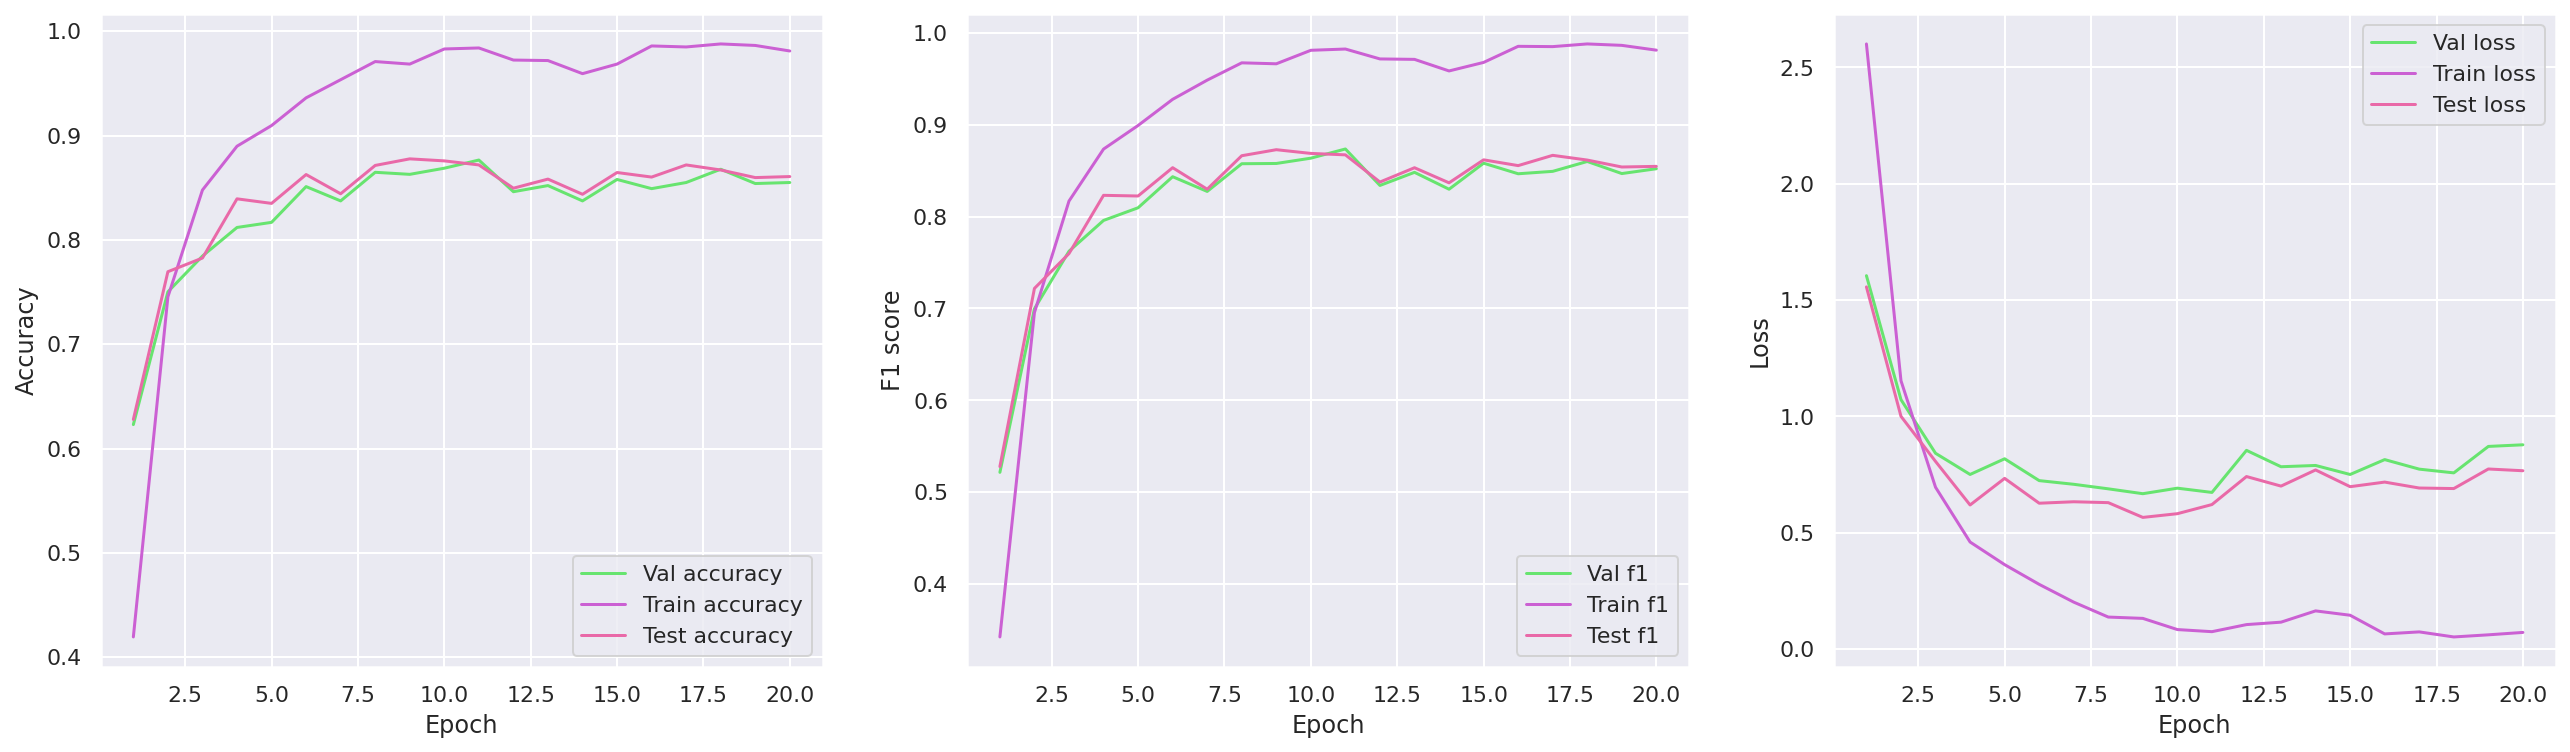

MAX TEST ACCURACY:  0.8777292576419214
MAX VAL ACCURACY:  0.8765915768854065
MAX TEST F1:  0.8727486499724002
MAX VAL F1:  0.8735341973368421
0.9810330014739359 0.8520386847558999 0.8546133041386884


In [19]:
val_ac, val_f1, val_loss, train_ac, train_f1, train_loss, test_ac, test_f1, test_loss = classification(model, optimizer, criterion, train_loader, val_loader, test_loader, 20)

# Save model

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
model.save_pretrained("/content/drive/MyDrive/model")

# Predictions on all data

In [ ]:
model.eval()
res = dml.copy()
res['type'] = '*'
res['predicted_graph_vertex_id'] = '*'
res['predicted_graph_vertex_prob'] = '*'
for ind, row in tqdm(dml.iterrows()):
    if ind in X_train.index:
        res.loc[ind, 'type'] = 'train'
    elif ind in X_test.index:
        res.loc[ind, 'type'] = 'test'
    else:
        res.loc[ind, 'type'] = 'val'
    
    snippet = preprocess_snippet(row['code_block'])
    snippet = tokenizer.batch_encode_plus([snippet], add_special_tokens=True, padding='max_length', truncation=True, return_tensors='pt', max_length=512)
    input_ids, attention_mask = snippet['input_ids'], snippet['attention_mask']
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
    with torch.inference_mode():
        logits = model(input_ids, attention_mask)['logits']
    vertex = F.softmax(logits, dim=-1).argmax(dim=-1).item()
    prob = F.softmax(logits, dim=-1).max(dim=-1)[0].item()
    res.loc[ind, 'predicted_graph_vertex_id'] = vertex
    res.loc[ind, 'predicted_graph_vertex_prob'] = prob

5152it [03:03, 28.00it/s]


In [ ]:
res

,code_block,too_long,marks,graph_vertex_id,type,predicted_graph_vertex_id,predicted_graph_vertex_prob
3149,#Sorting values\ns_corr_list = sorted(corr_lis...,Yes,5,9.0,train,8,0.994229
2308,"fig, ax = plt.subplots(5, 1, figsize=(15,10))\...",No,5,75.0,train,54,0.99681
4791,# Prepare Data for Submission to Kaggle\ndf_te...,No,5,45.0,train,37,0.999348
1699,# Promo\n\n# Plot average sales & customers wi...,No,5,33.0,train,28,0.976355
7494,"df[""radial60""]=np.sqrt(np.power(df[\'rot60_X\'...",No,5,8.0,val,7,0.996547
...,...,...,...,...,...,...,...
7071,lr = LinearRegression(),No,5,4.0,test,3,0.996176
724,from sklearn.model_selection import GridSearch...,No,5,22.0,test,21,0.998867
4991,"%%time\nevent_type=pd.read_csv(""../input/event...",No,5,45.0,test,37,0.999619
6073,"y_dat.rename(columns = {'0':'medium', '1':'low...",No,5,61.0,train,49,0.99627


In [ ]:
res['markup_index'] = res.index
res.to_csv('clear_markup_data_with_predictions.csv', index=False)

In [ ]:
res_c = pd.read_csv('clear_markup_data_with_predictions.csv')
res_c.head()

,code_block,too_long,marks,graph_vertex_id,type,predicted_graph_vertex_id,predicted_graph_vertex_prob,markup_index
0,#Sorting values\ns_corr_list = sorted(corr_lis...,Yes,5,9.0,train,8,0.994229,3149
1,"fig, ax = plt.subplots(5, 1, figsize=(15,10))\...",No,5,75.0,train,54,0.996810,2308
2,# Prepare Data for Submission to Kaggle\ndf_te...,No,5,45.0,train,37,0.999348,4791
3,# Promo\n\n# Plot average sales & customers wi...,No,5,33.0,train,28,0.976355,1699
4,"df[""radial60""]=np.sqrt(np.power(df[\'rot60_X\'...",No,5,8.0,val,7,0.996547,7494


# Metrics analysis

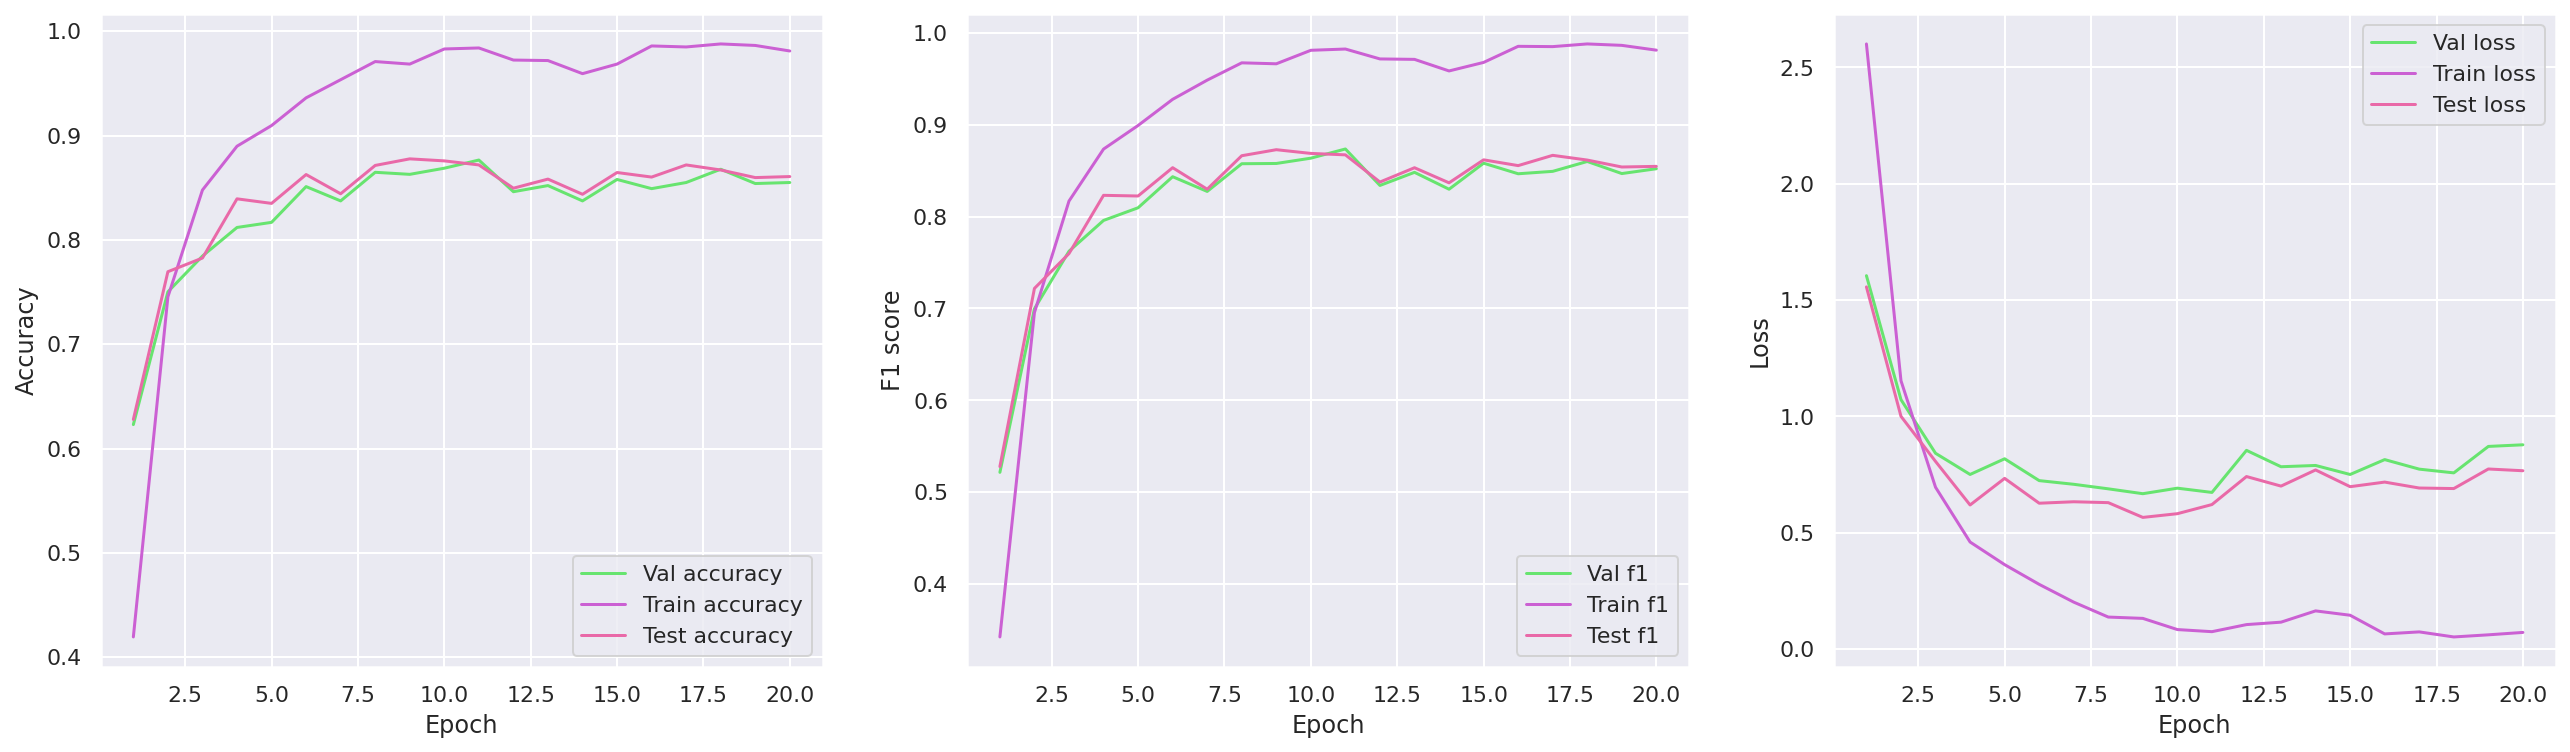

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(22,6))

i = 20

ax[0].plot(np.arange(1, i + 1), val_ac, color="#67E46F", label='Val accuracy') 
ax[0].plot(np.arange(1, i + 1), train_ac, color="#CB60D3", label='Train accuracy')
ax[0].plot(np.arange(1, i + 1), test_ac, color="#E969A8", label='Test accuracy')

ax[1].plot(np.arange(1, i + 1), val_f1, color="#67E46F", label='Val f1') 
ax[1].plot(np.arange(1, i + 1), train_f1, color="#CB60D3", label='Train f1')
ax[1].plot(np.arange(1, i + 1), test_f1, color="#E969A8", label='Test f1')

ax[2].plot(np.arange(1, i + 1), val_loss, color="#67E46F", label='Val loss') 
ax[2].plot(np.arange(1, i + 1), train_loss,  color="#CB60D3", label='Train loss')
ax[2].plot(np.arange(1, i + 1), test_loss, color="#E969A8", label='Test loss')


ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()
ax[1].set_ylabel('F1 score')
ax[1].set_xlabel('Epoch')
ax[1].legend()
ax[2].legend()
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')

plt.show()

filename = 'metrics_codebert.pdf'
fig.savefig(filename, bbox_inches='tight')
files.download(filename)

In [26]:
filename = 'metrics_codebert.txt'
f = open(filename, 'w')
print('val_ac', file=f)
print(*val_ac, file=f) 
print('train_ac', file=f)
print(*train_ac, file=f) 
print('test_ac', file=f)
print(*test_ac, file=f) 

print('val_f1', file=f)
print(*val_f1, file=f) 
print('train_f1', file=f)
print(*train_f1, file=f) 
print('test_f1', file=f)
print(*test_f1, file=f) 


print('val_loss', file=f)
print(*val_loss, file=f) 
print('train_loss', file=f)
print(*train_loss, file=f) 
print('test_loss', file=f)
print(*test_loss, file=f) 



f.close()
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# BERT


In [ ]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=65)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BATCH_SIZE = 16

train_dataset = SnippetsDataset(X_train, y_train)
test_dataset = SnippetsDataset(X_test, y_test)
val_dataset = SnippetsDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00007)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
val_ac, val_loss, train_ac, train_loss, test_ac, test_loss = classification(model, optimizer, criterion, train_loader, val_loader, test_loader, 20)